# <u>Feature Engineering and Machine Learning</u>

#### Imports

In [1]:
import pandas as pd
import numpy as np
import ast

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Solve KNN error
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import networkx as nx
from pyvis.network import Network

In [2]:
df = pd.read_csv("RecipeDataEDAed.csv")
# Dropping additional index column
df = df.drop(df.columns[0], axis = 1)
df["Ingredients"] = df["Ingredients"].apply(ast.literal_eval)
df = df.drop("Recipe", axis =1)
print(df.shape)
df.head()

(10518, 13)


,Rating,Number of Raters,Time,Categories,Servings,Ingredients,Instructions,Calories,Fat,Carbs,Proteins,Year,Month
0,5.0,0.000000,2.302585,Breakfast,0.000000,"[pepper, cheese, salt, egg, waffle, syrup]",4.955827,6.095825,3.178054,3.663562,2.890372,2023,4
1,5.0,1.098612,3.332205,Appetizer,1.386294,"[parsley, worcestershire, pepper, salt, season...",4.634729,5.231109,1.609438,1.386294,3.367296,2022,9
2,4.6,1.609438,2.708050,Breakfast,2.079442,"[cheese, dough, cinnamon, cherry, roll, cream,...",5.003946,5.424950,2.772589,2.772589,1.609438,2022,8
3,5.0,0.693147,3.912023,Appetizer,3.871201,"[salmon, wonton, cheese, onion, water, caper, ...",5.327876,3.637586,0.000000,1.609438,0.000000,2022,11
4,4.0,0.000000,3.555348,Appetizer,2.772589,"[cheese, raspberry, phyllo, dough, honey, salt...",5.117994,5.529429,2.772589,3.135494,1.386294,2022,10


Removing rows with infinte numbers from the DataFrame 

In [3]:
category_df = pd.DataFrame()
df["Categories"].value_counts()

#Removing text columns for the isfinite function
category_df["Categories"]= df["Categories"]
category_df["Ingredients"]= df["Ingredients"]

#Removing non-finite columns
df = df.drop(["Categories","Ingredients"], axis = 1)
df = df[np.isfinite(df).all(1)]

#Adding back the text columns
df = df.merge(category_df, left_index = True, right_index = True)

print(df["Categories"].value_counts())
df.head()


Dinner       3774
Dessert      2352
Appetizer    1262
Breakfast     826
Side Dish     790
Lunch         592
Drink         121
Name: Categories, dtype: int64


,Rating,Number of Raters,Time,Servings,Instructions,Calories,Fat,Carbs,Proteins,Year,Month,Categories,Ingredients
0,5.0,0.000000,2.302585,0.000000,4.955827,6.095825,3.178054,3.663562,2.890372,2023,4,Breakfast,"[pepper, cheese, salt, egg, waffle, syrup]"
1,5.0,1.098612,3.332205,1.386294,4.634729,5.231109,1.609438,1.386294,3.367296,2022,9,Appetizer,"[parsley, worcestershire, pepper, salt, season..."
2,4.6,1.609438,2.708050,2.079442,5.003946,5.424950,2.772589,2.772589,1.609438,2022,8,Breakfast,"[cheese, dough, cinnamon, cherry, roll, cream,..."
3,5.0,0.693147,3.912023,3.871201,5.327876,3.637586,0.000000,1.609438,0.000000,2022,11,Appetizer,"[salmon, wonton, cheese, onion, water, caper, ..."
4,4.0,0.000000,3.555348,2.772589,5.117994,5.529429,2.772589,3.135494,1.386294,2022,10,Appetizer,"[cheese, raspberry, phyllo, dough, honey, salt..."


Function receives the DataFrame and without_ing flag, and returns X, y (dataframe without categories, and categories column).</br>
It samples the over-represented categories, to create more homogeneous DataFrame.</br>
If the without_Ing flag is turned on, it drops the ingredient column.</br>
If the without_Ing flag is turned off, it keeps it in X.</br>


In [4]:
def sample_categories(df, without_ing):
    # Sampling the over represented categories
    dinner_df = df[df['Categories'] == 'Dinner'].sample(n=800, random_state=1)
    dessert_df = df[df['Categories'] == 'Dessert'].sample(n=800, random_state=1)
    appetizer_df = df[df['Categories'] == 'Appetizer'].sample(n=800, random_state=1)
    
    # Removing the the over represented categories
    df = df[df['Categories'] != 'Dinner']
    df = df[df['Categories'] != 'Dessert']
    df = df[df['Categories'] != 'Appetizer']

    # Adding the samples back to the DataFrame
    df = pd.concat([df.reset_index(drop = True), dinner_df.reset_index(drop = True)], axis=0)
    df = pd.concat([df.reset_index(drop = True), dessert_df.reset_index(drop = True)], axis=0)
    df = pd.concat([df.reset_index(drop = True), appetizer_df.reset_index(drop = True)], axis=0)
    df = df.reset_index(drop = True)

    X = df.drop("Categories", axis = 1)
    y = df["Categories"]
    
    #check if flag is turned on
    if without_ing:
        X = X.drop("Ingredients", axis = 1)
        
    return X, y





In [5]:
X, y = sample_categories(df, 1)

## <u>Initial Goal: predicting the rating of recipes</u>

The initial goal was to predict recipe ratings based on ingredient combinations.

Our data was extracted from "allrecipes.com," and during the exploratory data analysis (EDA) stage, we observed that most recipes were rated between 4 and 5 stars. There were very few low-rated recipes, and even fewer low-rated recipes with more than 20 raters. Having a decent number of raters is crucial for predicting ratings because recipes with a low number of raters can be easily manipulated to receive higher or lower ratings.

Due to the rarity of low-rated recipes, our DataFrame was unbalanced. To address this issue, we decided to bin our data instead of using LinearRegression. We attempted various binning approaches, including 6, 5, 4, 3, and even 2 bins with an equal number of recipes in each bin. As we reduced the number of bins, the accuracy of our predictions improved. However, even with 2 bins, our accuracy score was only 65%, which is only slightly better than flipping a coin.

We tried several techniques to improve our predictions, such as switching between MinMaxScaler and Log Transformation, modifying the handling of outliers (from complete removal to replacing high outliers with the upper whisker value, q3+1.5σ), adjusting hyperparameters in the MLPClassifier (changing the number of hidden layers, their distribution, activation function, and learning rate), and exploring alternative representations of ingredients (using their relative weight in the recipe instead of one-hot encoding, although this approach had limitations due to ingredient splitting during preprocessing).

Unfortunately, none of the above methods improved our predictions significantly, and we only achieved a 68% accuracy score with 2 bins.

At that point, we decided to change our approach and reconsider the problem. Instead of focusing on how we could manipulate and work with the data, we thought about what we might have overlooked. As mentioned earlier, the vast majority of our recipes were rated between 4 and 5 stars, making it challenging to distinguish between "excellent" and "perfect" recipes with the available data. We came up with a few explanations for this: </br>
1) When users browse an online recipe, the first thing that catches their eye is the recipe's photo or video.</br>
2) The quantity of ingredients, not just their presence, plays a crucial role in achieving high ratings.</br>

Based on these observations, we made the decision to change the goal of our project from predicting ratings to predicting recipe categories. This change aligns well with our data since most recipes are considered "excellent" or "perfect". We can utilize the one-hot encoding technique, which focuses on the presence of ingredients rather than their quantities. This approach fits our initial goal of predicting based on ingredient combinations.

## <u> Predicting Categories</u>

We are attempting to classify recipes into the following categories: Appetizer, Breakfast, Dessert, Dinner, Drink, Lunch, and Side Dish.

During the Data cleaning stage, a significant portion of our pre-processing involved extracting the names of ingredients from the ingredients lists. However, we questioned whether this step was even necessary.

To address this question, we decided to conduct a prediction experiment using only the data from other columns: Rating, Number of Raters, Time, Servings, Instructions, Calories, Fat, Carbs, Proteins, Year, and Month.

Afterward, we will incorporate one-hot encoded ingredient columns into the DataFrame, along with the remaining columns, and  predict again. We will then compare the results between the two approaches.

### <u>Without Ingredients</u>

Predicting categories without ingredients.

#### <u>KNN</u>

In [6]:
clf = KNeighborsClassifier()
params = {"n_neighbors" :[3,5,7,9,15]}
clfcv = GridSearchCV(clf, params, cv=10)
clfcv.fit(X, y)
print("Best parameters: {}".format(clfcv.best_params_))
print("Best Score: {}".format(clfcv.best_score_))


Best parameters: {'n_neighbors': 15}
Best Score: 0.4366762819364317


#### <u>Desicion Tree</u>

In [7]:
clf = DecisionTreeClassifier()
params = {"max_depth" :[2,3,4,5], "min_samples_split":[2,3,5,7,10]}
clfcv = GridSearchCV(clf, params, cv=10)
clfcv.fit(X, y)
print("Best parameters: {}".format(clfcv.best_params_))
print("Best Score: {}".format(clfcv.best_score_))


Best parameters: {'max_depth': 5, 'min_samples_split': 5}
Best Score: 0.44344384921345903


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### <u>Naive Bayes</u>

In [9]:
clf = GaussianNB()
clf.fit(X_train, y_train)
print("Score: {}".format(clf.score(X_test,y_test)))

Score: 0.45348837209302323


#### <u>MLP Classifier</u>

In [10]:
clf = MLPClassifier(hidden_layer_sizes = (5,3,3) , random_state=1, max_iter= 3000, activation='relu')
clf.fit(X_train, y_train)
print("Score: {}".format(clf.score(X_test,y_test)))

Score: 0.17970401691331925


### <u>With Ingredients</u>

Predicting categories with ingredients.

#### <u>MLPClassifier</u>

Due to the structure of our DataFrame, which included the addition of one-hot encoded ingredient columns, it was suggested that we utilize the MLPClassifier algorithm.

The MLPClassifier is a neural network-based classification algorithm. One of its important hyperparameters is "hidden_layer_sizes," which determines the architecture of the network in terms of the number of hidden layers and the number of neurons in each layer. In our model, we have chosen to have 100 neurons in columns 2-6 and 69 neurons in column 1. Since our objective is to classify recipe categories based on their ingredients, it is crucial for our network to be "sparse" and have a sufficient number of columns to capture different ingredient combinations.

(4729, 569)


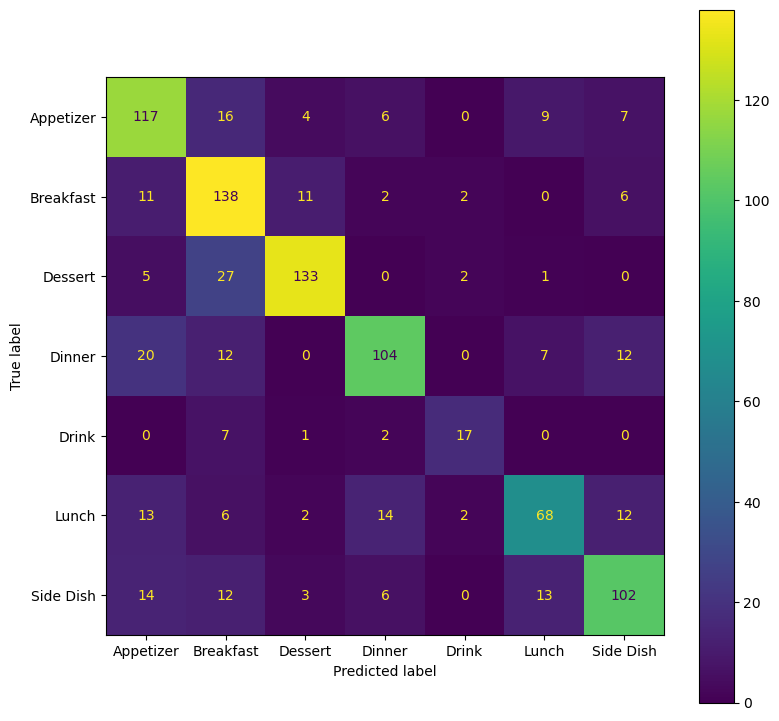

0.7177589852008457

In [11]:
X, y = sample_categories(df,0)

mlb = MultiLabelBinarizer()
encoded_ingredients = mlb.fit_transform(X["Ingredients"])
encoded_df_ing = pd.DataFrame(encoded_ingredients, columns=mlb.classes_)
X = X.merge(encoded_df_ing, left_index = True, right_index = True)
X = X.drop("Ingredients", axis =1)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
clf = MLPClassifier(hidden_layer_sizes = (69, 100, 100, 100, 100, 100) , random_state=1, max_iter= 3000, activation='relu').fit(X_train, y_train)
y_pred = clf.predict(X_test)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=clf.classes_ )
fig, ax = plt.subplots(figsize=(9,9))
disp.plot(ax=ax)
plt.show()
clf.score(X_test, y_test)

#### <u>Most common ingredients per category:</u>

In [12]:

# Recreating the df, addinng categories to X
ML_recipes = X.merge(y,left_index = True, right_index = True)
# Droping the all columns besides Ingredients
ML_recipes_Ing = ML_recipes.drop(['Rating', 'Number of Raters', 'Time', 'Servings', 'Instructions','Month',\
                              'Calories', 'Fat', 'Carbs', 'Proteins', 'Year'], axis = 1)
ingredient_counts = ML_recipes_Ing.groupby('Categories').sum()


In [13]:

ingredient_counts = ingredient_counts.transpose() 
for column in ingredient_counts:
    # Sort the column in descending order and get the top 10 values
    top_10_values = ingredient_counts[column].nlargest(10)
    print("{} : {}".format(column, top_10_values.index.tolist()))


Appetizer : ['salt', 'pepper', 'cheese', 'oil', 'onion', 'cream', 'egg', 'sauce', 'butter', 'flour']
Breakfast : ['egg', 'salt', 'sugar', 'milk', 'flour', 'butter', 'cinnamon', 'cheese', 'vanilla', 'oil']
Dessert : ['sugar', 'egg', 'butter', 'flour', 'vanilla', 'salt', 'milk', 'cream', 'cinnamon', 'soda']
Dinner : ['pepper', 'salt', 'onion', 'oil', 'garlic', 'sauce', 'cheese', 'chicken', 'water', 'tomato']
Drink : ['milk', 'sugar', 'ice', 'vanilla', 'banana', 'yogurt', 'water', 'cream', 'strawberry', 'juice']
Lunch : ['onion', 'pepper', 'salt', 'oil', 'mayonnaise', 'vinegar', 'cheese', 'tomato', 'sugar', 'celery']
Side Dish : ['salt', 'pepper', 'oil', 'onion', 'butter', 'potato', 'sugar', 'cheese', 'garlic', 'water']


<u>Visualizing top 10 ingredients for each category and their connections:</u>

In [14]:
top_ingredients = {}
columns = ingredient_counts.columns
for column in columns:
    # Sort the column in descending order and get the top 10 values
    top_10_values = ingredient_counts[column].nlargest(10)
    top_10_values = top_10_values.index.tolist()
    top_ingredients[column] = top_10_values

# Create an empty graph
G = nx.Graph()

category_colors = {
    'Appetizer': 'rgb(255, 0, 0)',  # Red
    'Breakfast': 'rgb(0, 255, 0)',  # Green
    'Dessert': 'rgb(0, 0, 255)',    # Blue
    'Dinner': 'rgb(255, 255, 0)',   # Yellow
    'Drink': 'rgb(255, 0, 255)',    # Magenta
    'Lunch': 'rgb(0, 255, 255)',    # Cyan
    'Side Dish': 'rgb(255, 128, 0)' # Orange
}

# Add nodes to the graph (categories and ingredients)
categories = top_ingredients.keys()
ingredients = [ingredient for ingredients_list in top_ingredients.values() for ingredient in ingredients_list]
G.add_nodes_from(categories)
G.add_nodes_from(ingredients)

# Add edges between categories and their corresponding ingredients
for category, ingredients_list in top_ingredients.items():
    G.add_edges_from([(category, ingredient) for ingredient in ingredients_list])

# Create a pyvis network
nt = Network(height="500px", width="100%", notebook=True)

# Define node positions using a circular layout
pos = nx.kamada_kawai_layout(G, scale=500)

# Add nodes
for node in G.nodes():
    if node in categories:
        color = category_colors[node]
        physics = False  # Disable physics for category nodes
    else:
        color = 'silver'
        physics = True  # Enable physics for ingredient nodes
    nt.add_node(node, color=color, x=pos[node][0], y=pos[node][1], physics=physics)

# Add edges
for edge in G.edges():
    nt.add_edge(edge[0], edge[1])

# Show the network
nt.show("graph.html")

#
#The graph is in the README file
#

graph.html


### <u>Results Explanation</u>

#### <u>Predicting with and without ingredients</u> 

The inclusion of ingredients significantly enhanced our prediction performance, resulting in a 26.5% improvement. Comparing the accuracy scores, the model without ingredients achieved the highest accuracy of 45.3% using the Naive Bayes algorithm. In contrast, the model incorporating ingredients, the MLPClassifier, achieved a significantly higher accuracy score of 71.7%.

These results indicate that different combinations of ingredients are indicative of distinct meal types and dishes. The presence of specific ingredients appears to play a crucial role in determining the recipe category accurately.


#### <u>Ingredients Confusion matrix results</u>

The model's task is to classify recipes into the following categories: Appetizer, Breakfast, Dessert, Dinner, Drink, Lunch, and Side Dish.</br> Determining when and what to eat are subjective choices, making recipe classification challenging even for humans.

Furthermore, as mentioned previously, the categories are not entirely distinct. We can logically divide them into two main groups: "Time" and "Dish Type."

The "Time" categories represent when we typically consume the food and include Breakfast, Lunch, and Dinner. The "Dish Type" categories represents the type of dish and portion size, and include: Appetizer, Dessert, Drink, and Side Dish.

There is a potential overlap between the "Time" and "Dish Type" categories due to the fact that certain dishes are primarily consumed at specific times of the day. As a result, our model may classify "Time" categories as "Dish Type" categories, and vice versa.

Among the categories, Lunch poses the lowest prediction rate and proves to be the most challenging to predict accurately. Lunch falls between Breakfast and Dinner and shares attributes of both, while also allowing for the including types of dishes from the "Dish Type" categories. Additionally, Lunch had fewer recipes in our dataset compared to the other categories (excluding Drink), which could contribute to the model's difficulty in classifying it correctly. Out of 117 Lunch recipes, our model classified 68 of them as "Lunch," resulting in a 58.1% accuracy rate.

On the other hand, the Breakfast category boasts the highest prediction rate. This can be attributed to the fact that breakfasts often consist of one-dish meals that are typically lighter. This similarity can lead to confusion with Appetizer and Side Dish categories. Additionally, breakfasts are the only meals that commonly incorporate sweet flavors and ingredients, which may cause confusion with the Dessert category. Out of 170 breakfast recipes, our model accurately classified 138 as "Breakfast," achieving an 81.1% accuracy rate.

The Drink category has the fewest number of samples. We decided to include it as a category, assuming it had distinct characteristics. Analyzing the most popular ingredients in Drinks, we found that they often consist of various liquid ingredients (such as juice, water, milk, yogurt, ice, and cream, which likely refers to ice cream). Additionally, Drinks commonly feature fruits, which we assume are also frequently consumed at breakfast. Our model successfully classified 17 out of 27 drinks as "Drink," resulting in a 62.9% accuracy rate.

#### <u>Conclusion</u>

In conclusion, our project focused on predicting recipe categories based on ingredient combinations. We experimented with different approaches, including analyzing the data without considering ingredients and with ingredient information using one-hot encoding. The inclusion of ingredients significantly improved our prediction accuracy by 26.5%. We found that different combinations of ingredients were indicative of distinct meal types and dishes. While some confusion existed between "Time" and "Dish Type" categories, our model demonstrated reasonably accurate classification rates, with Breakfast achieving the highest accuracy and Lunch posing the greatest challenge. Overall, this project highlights the importance of ingredient data in accurately classifying recipe categories and provides insights into the complex nature of meal classification.